# Post Topics from Posts in the r/Python subreddit

The aim of this project is to classify the topic of posts from the r/Python subreddit from end-to-end. In order to do this, I first needed to scrape a sufficient number of posts for an accurate NLP model. I have done this via this [submission downloader code](https://github.com/dgadish/projects/blob/master/NLP/Reddit_Scrape_Analysis/Reddit%20Submission%20downloader.ipynb) . 

Once a sufficient number of submissions were scraped, I read them into a pandas dataframe in order to clean them sufficiently to be fed into a model.

The submissions were collected at around 10:00 on 07/02/2021

The submissions have both title and text sections. I will attempt to determine topics using both. 

I will attempt to use both LSA (Latent Semantic Analysis) and LDA (Latent Dirichlet Allocation) to determine the topics of each post. When I have more time, I will attempt to use Word Embedding combined with something like K-Means clustering as well.

### Progress so far...

So far I have imported the submissions and I have cleaned and preprocessed the text sections of the submissions. I have then created a bag-of-words model for the text column and used it to train an LDA model.

### Next steps...

Next I need to play around with the parameters of the model to find suitable topics with which I can label and then assign to submissions. 

In [1]:
import nltk
#nltk.download('all')
import gensim
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
subs = pd.read_json('python_posts.json', orient='index')

In [3]:
subs.head()

,title,subreddit,score,num_comments,created_utc,selftext
1,Python conversion tool for converting csv to J...,Python,1,1,1612467290,[removed]
2,lynda courses,Python,1,2,1612466655,[removed]
3,Anybody have sample code to determine if a web...,Python,4,5,1612466550,"Hi, has anyone created python code that tests ..."
5,Barnsley Fern - an interesting fractal created...,Python,1,0,1612465003,[deleted]
6,Project – Find Neapolitan pizza with AI help,Python,2,0,1612464251,Just finished this project! An unfiltered revi...


In [4]:
subs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26003 entries, 1 to 40100
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         26003 non-null  object
 1   subreddit     26003 non-null  object
 2   score         26003 non-null  int64 
 3   num_comments  26003 non-null  int64 
 4   created_utc   26003 non-null  int64 
 5   selftext      26003 non-null  object
dtypes: int64(3), object(3)
memory usage: 1.4+ MB


In [5]:
# Drop submissions which have been removed or deleted

n_r_d = (subs['selftext'] != '[removed]') & (subs['selftext'] != '[deleted]')
subs_1 = subs[n_r_d]
subs_1.reset_index(drop=True, inplace=True)

In [6]:
subs_1.head()

,title,subreddit,score,num_comments,created_utc,selftext
0,Anybody have sample code to determine if a web...,Python,4,5,1612466550,"Hi, has anyone created python code that tests ..."
1,Project – Find Neapolitan pizza with AI help,Python,2,0,1612464251,Just finished this project! An unfiltered revi...
2,"In response to the ""Medium bad"" thread, here a...",Python,9,4,1612460552,I agree with some of the sentiments shared in ...
3,To open source or not to open source?,Python,3,8,1612453887,When do you guys know when to open source a pr...
4,How can i decrypt signature Url of YouTube Videos,Python,2,3,1612453834,I made a python module which download youtube ...


In [7]:
subs_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18102 entries, 0 to 18101
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         18102 non-null  object
 1   subreddit     18102 non-null  object
 2   score         18102 non-null  int64 
 3   num_comments  18102 non-null  int64 
 4   created_utc   18102 non-null  int64 
 5   selftext      18102 non-null  object
dtypes: int64(3), object(3)
memory usage: 848.7+ KB


### Data cleaning and pre-processing

Now that I have collected a sufficiently large data set and dropped any submissions that were deleted or removed, I can begin to clean the data set. For now my cleaning will be focused on preparing the data for a bag-of-words model, suitable for LSA and LDA

I will begin with the 'selftext' column and then move to the 'title' column.

**Selftext**

I will start by removing the url's which are included in a number of the submissions. I have taken a regex expression from [Github Gist user gruber](https://gist.github.com/gruber/8891611). To remove urls with pandas methods.

In [8]:
# First create a new copy of the dataframe

subs_2 = subs_1.copy()

# Remove url's with provided regex

rgx = r"(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))"
subs_2['selftext'] = subs_2['selftext'].str.replace(rgx," ")

Next I shall remove punctuation, tokenize the text and remove any stop words and words less than 4 letters long

In [9]:
# Remove punctuation and convert all to lowercase

subs_2['selftext'] = subs_2['selftext'].str.replace('\W', ' ').str.lower()

# Tockenize

subs_2['selftext'] = subs_2['selftext'].apply(nltk.word_tokenize)


In [10]:
# Remove stop words and anything less than 4 letters long
''' 
By the very nature of the subreddit, every submission should be about python.
As such, the word 'python' can also be removed.

After running the model, the term 'x200b' is common. 
This is to do with a zero-width space character and is in the dataset due to how the data is encoded. 
It does not add any information and so will be removed.
'''

stopwords = set(nltk.corpus.stopwords.words('english'))
stopwords.add('python')
stopwords.add('x200b')

def no_stop(list):
    
    nostops = []
    
    for l in list:
        if l not in stopwords:
            nostops.append(l)
    
    return nostops

            
def no_short(list):
    
    noshort = []
    
    for l in list:
        if len(l) >= 4:
            noshort.append(l)
    
    return noshort


In [11]:
strin = 'This is a test string to see if my functions work super duper well'
strin = nltk.word_tokenize(strin)

In [12]:
no_stop(strin)

['This',
 'test',
 'string',
 'see',
 'functions',
 'work',
 'super',
 'duper',
 'well']

In [13]:
no_short(strin)

['This', 'test', 'string', 'functions', 'work', 'super', 'duper', 'well']

In [14]:
# Apply my tested functions to the 'selftext' column

subs_2['selftext'] = subs_2['selftext'].apply(no_stop).apply(no_short)

In [15]:
subs_2['selftext'].head()

0    [anyone, created, code, tests, page, different...
1    [finished, project, unfiltered, review, pizza,...
2    [agree, sentiments, shared, thread, medium, tu...
3    [guys, know, open, source, project, working, p...
4    [made, module, download, youtube, videos, with...
Name: selftext, dtype: object

The next step in processing the data is to lemmetize and stem the words to bring everything into the present tense and remove endings such as 'ed', 'ly', 's' etc.

This can be done using proven functions in the nltk package.

In [16]:
wnl = nltk.stem.WordNetLemmatizer()
stemmer = nltk.stem.SnowballStemmer('english')

wnl.lemmatize() takes two arguements, the word and a 'part-of-speech' tag. For now I will focus on just converting the verbs, pos='v', but I may come back to this in the future to ammend it to account for all words such that the stemmer, which results in stems wich aren't proper English, isn't needed.

In [17]:
# Function to lemmatize and stem the text

def lemmatize_stemmer(list):
    new_list = []
    for word in list:
        new_list.append(stemmer.stem(wnl.lemmatize(word, pos='v')))
        
    return new_list

In [18]:
# Test function of some rows in subs_2

slftxt = subs_2['selftext'][1]
print(slftxt)
cleaned = lemmatize_stemmer(slftxt)
print(cleaned)

['finished', 'project', 'unfiltered', 'review', 'pizza', 'places', 'city', 'authentic', 'pizza', 'places', 'boston', 'said', 'combining', 'computer', 'vision', 'machine', 'learning', 'ease', 'search', 'neapolitan', 'pizza', 'based', 'photos', 'public', 'crowd', 'sourced', 'reviews', 'check', 'city', 'learn', 'going', 'hood', 'would', 'glad', 'receive', 'feedback']
['finish', 'project', 'unfilt', 'review', 'pizza', 'place', 'citi', 'authent', 'pizza', 'place', 'boston', 'say', 'combin', 'comput', 'vision', 'machin', 'learn', 'eas', 'search', 'neapolitan', 'pizza', 'base', 'photo', 'public', 'crowd', 'sourc', 'review', 'check', 'citi', 'learn', 'go', 'hood', 'would', 'glad', 'receiv', 'feedback']


Although not perfect, this will be good enough for the purpose of this project at this stage. The function will now be applied to subs_2.

In [19]:
subs_2['selftext'] = subs_2['selftext'].apply(lemmatize_stemmer)

In [20]:
subs_2['selftext'].head()

0    [anyon, creat, code, test, page, differ, previ...
1    [finish, project, unfilt, review, pizza, place...
2    [agre, sentiment, share, thread, medium, turn,...
3    [guy, know, open, sourc, project, work, projec...
4    [make, modul, download, youtub, video, without...
Name: selftext, dtype: object

The next step is to produce a bag-of-words model from the texts. This can be done with the assistance of the gensim package.

First, a dictionary containing a word count for each word will be produced. This will then be cut down by filtering out any words that appear in less than 20 documents and in more than 50 % as these words will be be either to rare or to common to use to classify topics.

Once this has been done, the dictionary will be used to create a bag-of-words model for each submission in the data set.

In [21]:
slf_dictionary = gensim.corpora.Dictionary(subs_2['selftext'])
slf_dictionary.filter_extremes(no_below=20, no_above=0.5)
slf_bow_corpus = [slf_dictionary.doc2bow(doc) for doc in subs_2['selftext']]

In [22]:
# Preview BOW for the nth submission in the data set

slf_bow_first_sub = slf_bow_corpus[0]

for i in range(len(slf_bow_first_sub)):
    print(f'Word {slf_bow_first_sub[i][0]} ("{slf_dictionary[slf_bow_first_sub[i][0]]}") appears {slf_bow_first_sub[i][1]} time.')

Word 0 ("anyon") appears 2 time.
Word 1 ("autom") appears 1 time.
Word 2 ("basic") appears 1 time.
Word 3 ("code") appears 1 time.
Word 4 ("creat") appears 1 time.
Word 5 ("differ") appears 1 time.
Word 6 ("display") appears 1 time.
Word 7 ("enough") appears 1 time.
Word 8 ("get") appears 1 time.
Word 9 ("keep") appears 1 time.
Word 10 ("need") appears 1 time.
Word 11 ("page") appears 2 time.
Word 12 ("previous") appears 1 time.
Word 13 ("process") appears 1 time.
Word 14 ("refresh") appears 1 time.
Word 15 ("right") appears 1 time.
Word 16 ("test") appears 1 time.
Word 17 ("ticket") appears 1 time.
Word 18 ("tri") appears 1 time.


In [23]:
# What does slf_bow_corpus actually look like?

print(slf_bow_corpus[:1])

[[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1)]]


### Selftext Topic Model (LDA)

The bag-of-words model based on the selftext column is now ready to train a model. I have chosen to start with LDA. In addition to the corpus and the dictionary, the number of topics also needs to be provided. At this time I shall train the model for 10 topics. In the future, I may look to find a way to determine the optimum number of topics.

I will run LDA using multiple CPU cores to parallelize and speed up the model training. 

some of the parameters involved are

* **num_topics** is the number of topics to be extracted from the corpus.
* **id2word** is a mapping from word id's to the actual words, in this case, our dictionary.
* **workers** is the number of extra cores to use.
* **passes** is the number of training passes through the corpus.


In [24]:
slf_lda = gensim.models.LdaMulticore(slf_bow_corpus, num_topics=10, 
                                     id2word= slf_dictionary, passes=10, workers=2)

In [25]:
# Compute coherence score (used to judge how good a model is, higher is better)

slf_lda_coherence_model = gensim.models.CoherenceModel(model=slf_lda, texts=subs_2['selftext'], 
                                                       dictionary=slf_dictionary, coherence='c_v')
slf_lda_coherence = slf_lda_coherence_model.get_coherence()

print(f'Coherence Score: {slf_lda_coherence:.2f}')

Coherence Score: 0.60


In [26]:
# Visualise the topics

for idx, topic in slf_lda.print_topics(-1):
    print(f'Topic: {idx} \nWords: {topic}')
    print('\n') 

Topic: 0 
Words: 0.022*"use" + 0.018*"project" + 0.013*"librari" + 0.010*"work" + 0.010*"code" + 0.009*"tool" + 0.009*"like" + 0.009*"make" + 0.009*"develop" + 0.009*"github"


Topic: 1 
Words: 0.030*"import" + 0.021*"request" + 0.020*"line" + 0.016*"file" + 0.016*"messag" + 0.015*"user" + 0.013*"data" + 0.013*"json" + 0.012*"server" + 0.012*"call"


Topic: 2 
Words: 0.051*"video" + 0.022*"use" + 0.022*"code" + 0.018*"make" + 0.015*"imag" + 0.015*"text" + 0.014*"link" + 0.014*"learn" + 0.014*"youtub" + 0.013*"turtl"


Topic: 3 
Words: 0.036*"learn" + 0.014*"start" + 0.014*"would" + 0.014*"program" + 0.013*"want" + 0.013*"project" + 0.013*"know" + 0.011*"like" + 0.010*"help" + 0.010*"cours"


Topic: 4 
Words: 0.021*"like" + 0.020*"make" + 0.020*"work" + 0.020*"code" + 0.016*"know" + 0.015*"would" + 0.015*"program" + 0.015*"tri" + 0.013*"want" + 0.012*"use"


Topic: 5 
Words: 0.044*"file" + 0.022*"script" + 0.016*"use" + 0.015*"want" + 0.014*"download" + 0.013*"would" + 0.012*"creat" + 0

### Number of topics optimisation

Now that I know that the model training works I need to determine the optimum number of topics. I shall do this by training models with different numbers of topics and then selecting the model with the largest coherence score. The coherence value seems to change every time the model is trained. As such I shall run the tests a number of time to determine the optimum.

In [27]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=4, step=2):
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = gensim.models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [57]:
model_list, coherence_values_1 = compute_coherence_values(dictionary=slf_dictionary, corpus=slf_bow_corpus, texts=subs_2['selftext'], limit=26)

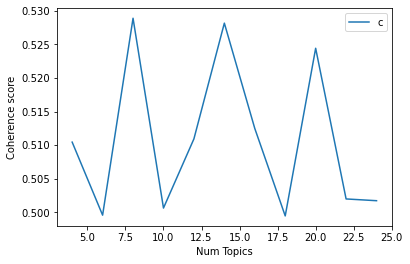

In [58]:
limit=26; start=4; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values_1)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [59]:
model_list, coherence_values_2 = compute_coherence_values(dictionary=slf_dictionary, corpus=slf_bow_corpus, texts=subs_2['selftext'], limit=26)

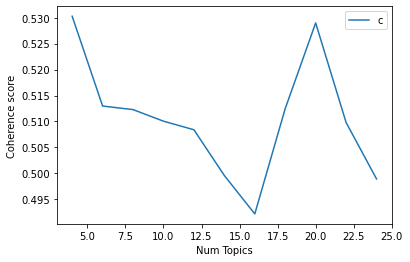

In [60]:
limit=26; start=4; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values_2)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [61]:
model_list, coherence_values_3 = compute_coherence_values(dictionary=slf_dictionary, corpus=slf_bow_corpus, texts=subs_2['selftext'], limit=26)

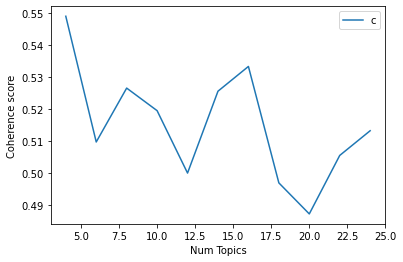

In [62]:
limit=26; start=4; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values_3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [63]:
model_list, coherence_values_4 = compute_coherence_values(dictionary=slf_dictionary, corpus=slf_bow_corpus, texts=subs_2['selftext'], limit=26)

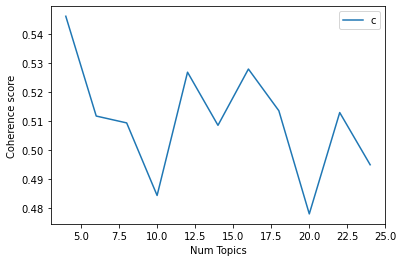

In [64]:
limit=26; start=4; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values_4)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [65]:
coherence_values = [np.array(coherence_values_1), np.array(coherence_values_2), np.array(coherence_values_3), np.array(coherence_values_4)]
mean_coherence = np.mean(coherence_values, axis=0)

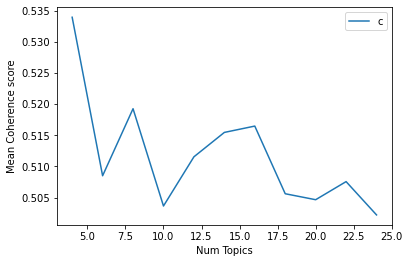

In [66]:
limit=26; start=4; step=2;
x = range(start, limit, step)
plt.plot(x, mean_coherence)
plt.xlabel("Num Topics")
plt.ylabel("Mean Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [67]:
mean_coherence

array([0.53399934, 0.50849986, 0.51928449, 0.5036335 , 0.51154736,
       0.51547222, 0.51649138, 0.50560674, 0.50464675, 0.50755799,
       0.50220087])

The testing suggests that the optimum number of topics is 4, followed by 8 and then 16. Not wanting to have too few topics, I shall work with 8.

*This result may change if the notebook is ran again from the begining*

In [80]:
slf_lda_8_1 = gensim.models.LdaMulticore(slf_bow_corpus, num_topics=8, 
                                     id2word= slf_dictionary, passes=10, workers=2)
slf_lda_coherence_model_8_1 = gensim.models.CoherenceModel(model=slf_lda_8_1, texts=subs_2['selftext'], 
                                                       dictionary=slf_dictionary, coherence='c_v')
slf_lda_coherence_8_1 = slf_lda_coherence_model_8_1.get_coherence()

In [81]:
slf_lda_8_2 = gensim.models.LdaMulticore(slf_bow_corpus, num_topics=8, 
                                     id2word= slf_dictionary, passes=10, workers=2)
slf_lda_coherence_model_8_2 = gensim.models.CoherenceModel(model=slf_lda_8_2, texts=subs_2['selftext'], 
                                                       dictionary=slf_dictionary, coherence='c_v')
slf_lda_coherence_8_2 = slf_lda_coherence_model_8_2.get_coherence()

In [82]:
slf_lda_8_3 = gensim.models.LdaMulticore(slf_bow_corpus, num_topics=8, 
                                     id2word= slf_dictionary, passes=10, workers=2)
slf_lda_coherence_model_8_3 = gensim.models.CoherenceModel(model=slf_lda_8_3, texts=subs_2['selftext'], 
                                                       dictionary=slf_dictionary, coherence='c_v')
slf_lda_coherence_8_3 = slf_lda_coherence_model_8_3.get_coherence()

In [83]:
slf_lda_8_4 = gensim.models.LdaMulticore(slf_bow_corpus, num_topics=8, 
                                     id2word= slf_dictionary, passes=10, workers=2)
slf_lda_coherence_model_8_4 = gensim.models.CoherenceModel(model=slf_lda_8_4, texts=subs_2['selftext'], 
                                                       dictionary=slf_dictionary, coherence='c_v')
slf_lda_coherence_8_4 = slf_lda_coherence_model_8_4.get_coherence()

In [84]:
print(f'Coherence Score 1: {slf_lda_coherence_8_1:.2f}')

print(f'Coherence Score 2: {slf_lda_coherence_8_2:.2f}')

print(f'Coherence Score 3: {slf_lda_coherence_8_3:.2f}')

print(f'Coherence Score 4: {slf_lda_coherence_8_4:.2f}')

Coherence Score 1: 0.56
Coherence Score 2: 0.59
Coherence Score 3: 0.57
Coherence Score 4: 0.57


The second model has the highest coherence score of 0.59 so I will move forward with this model.

In [85]:
for idx, topic in slf_lda_8_2.print_topics(-1):
    print(f'Topic: {idx} \nWords: {topic}')
    print('\n') 

Topic: 0 
Words: 0.038*"imag" + 0.032*"pygam" + 0.026*"game" + 0.021*"player" + 0.019*"color" + 0.017*"import" + 0.017*"button" + 0.015*"screen" + 0.014*"card" + 0.013*"self"


Topic: 1 
Words: 0.090*"print" + 0.037*"input" + 0.023*"return" + 0.020*"name" + 0.019*"line" + 0.018*"number" + 0.016*"els" + 0.016*"enter" + 0.015*"import" + 0.013*"elif"


Topic: 2 
Words: 0.022*"data" + 0.018*"list" + 0.017*"function" + 0.014*"valu" + 0.013*"text" + 0.013*"use" + 0.012*"need" + 0.012*"would" + 0.012*"column" + 0.010*"like"


Topic: 3 
Words: 0.035*"learn" + 0.015*"program" + 0.015*"start" + 0.014*"want" + 0.014*"know" + 0.014*"would" + 0.012*"project" + 0.012*"like" + 0.012*"help" + 0.010*"thank"


Topic: 4 
Words: 0.024*"use" + 0.019*"data" + 0.016*"project" + 0.013*"video" + 0.011*"librari" + 0.010*"github" + 0.010*"model" + 0.009*"code" + 0.008*"process" + 0.008*"sourc"


Topic: 5 
Words: 0.019*"work" + 0.018*"make" + 0.017*"like" + 0.017*"code" + 0.016*"use" + 0.014*"would" + 0.013*"scri

As such I am suggesting that the topics are as follows:

* Topic 0: Game development
* Topic 1: Code
* Topic 2: 
* Topic 3: Want to learn python
* Topic 4: Github project
* Topic 5: 
* Topic 6: Web Scraping
* Topic 7: Cython


I am not sure how to label topics 2 and 5 so I shall assgin topics to submissions and then use the submissions to determine the topic

### Assigning topics to submissions

The topic of each submission will be assigned as the most dominant topic for that submission.

In [101]:
def define_topics(ldamodel, corpus, submissions):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic and Perc Contribution for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4)]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution']

    # Add original text to the end of the output
    sent_topics_df = pd.concat([sent_topics_df, submissions], axis=1)
    return(sent_topics_df)

In [132]:
df_topic_sents_keywords = define_topics(ldamodel=slf_lda_8_2, corpus=slf_bow_corpus, submissions=subs_1[['selftext', 'title', 'score', 'num_comments', 'created_utc']])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Submission', 'Title', 'Score', 'num_comments', 'created_utc']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Submission,Title,Score,num_comments,created_utc
0,0,5.0,0.8396,"Hi, has anyone created python code that tests ...",Anybody have sample code to determine if a web...,4,5,1612466550
1,1,4.0,0.4226,Just finished this project! An unfiltered revi...,Project – Find Neapolitan pizza with AI help,2,0,1612464251
2,2,5.0,0.3615,I agree with some of the sentiments shared in ...,"In response to the ""Medium bad"" thread, here a...",9,4,1612460552
3,3,5.0,0.7148,When do you guys know when to open source a pr...,To open source or not to open source?,3,8,1612453887
4,4,5.0,0.4534,I made a python module which download youtube ...,How can i decrypt signature Url of YouTube Videos,2,3,1612453834
5,5,4.0,0.5506,"Hi, everyone!\n\nI made a video about how to b...",Real Time Django project with Chart.js and Dja...,3,0,1612451455
6,6,7.0,0.8277,Can someone please help me to resolve the issu...,Kali Linux Trity Download,0,14,1612443252
7,7,0.0,0.1250,[https://www.youtube.com/watch?v=Nsv14mjwnMk](...,Creating Virtual Environments in Python,4,2,1612442566
8,8,3.0,0.6112,Hello my name is Toni and I have master degree...,Looking for partner to help me build Bot for T...,0,9,1612441629
9,9,4.0,0.5397,I like to take pictures during my holiday and ...,I made a simple drag-and-drop symlinker to eas...,2,0,1612427863


In [105]:
pd.set_option('display.max_colwidth', None)

df_dominant_topic.loc[df_dominant_topic['Dominant_Topic'] == 2, ['Dominant_Topic', 'Submission']].head(20)

,Dominant_Topic,Submission
31,2.0,"When a function is used to decorate another function, the decorator will be lower case, when a class is used to decorate a function, the decorator will be upper case, if one follows naming conventions.\n\nBut my gut and the principle of least surprise tells me that there should be a rule whether decorators are lower or upper case.\n\nIs there? If not: should there be one?"
32,2.0,"When a function is used to decorate another function, the decorator will be lower case, when a class is used to decorate a function, the decorator will be upper case, if one follows naming conventions.\n\nBut my gut and the principle of least surprise tells me that there should be a rule whether decorators are lower or upper case.\n\nIs there? If not: should there be one?"
33,2.0,"When a function is used to decorate another function, the decorator will be lower case, when a class is used to decorate a function, the decorator will be upper case, if one follows naming conventions.\n\nBut my gut and the principle of least surprise tells me that there should be a rule whether decorators are lower or upper case.\n\nIs there? If not: should there be one?"
56,2.0,"I'm using matplotlib and numpy to create a visual representation of the sine and cosine. The output looked interesting in my opinion so I thought I should post it here for others to see.\n\n&amp;#x200B;\n\n`import numpy as np` \n`import matplotlib.pyplot as plt` \n`theta = np.linspace(0 ,8 * np.pi, 2000)` \n`r1 = np.random.rand() # r1 = cos(r1 * theta)` \n`r2 = np.random.rand() # r2 = sin(r2 * theta)` \n`# r1 and r2 are between 0 and 1` \n`x = np.cos(r1 * theta)` \n`y = np.sin(r2 * theta)` \n`plt.plot(x, y, ""k"")` \n`plt.axis(""square"")` \n`plt.axis([-1.1, 1.1, -1.1, 1.1])` \n`plt.axis(""off"")` \n`plt.title(f""r1={np.round(r1, 2)}, r2={np.round(r2, 2)}"")` \n[`plt.show`](https://plt.show)`()`"
98,2.0,"VIDEO: https://streamable.com/j3occ7\n\nRepo: https://github.com/Fitzy1293/daily-covid\n\nPypi: http://pypi.org/project/dailycovid\n\nData source: https://github.com/nytimes/covid-19-data\n\nIt can be used like that for a whole state or like this on the county level. \n\n`dailycovid -sc ""California-Los Angeles""`\n\n`dailycovid -s CA -c ""Los Angeles""`\n\n`dailycovid --state CA --county ""Los Angeles""`\n\nIt downloads the nytimes county level covid data on initial use, or when you use -g as a flag, and parses and splits it up by state into diff files. The actual downloading and creating the initial cache is the slowest, but you only have to do that once a day. \n\nNow data stored for each state in different files, when you run it again you just have to go through a file with like 1/50th the data to find a matching county. \n\nOnce it is cached it works well, takes about 1.5 seconds per county, there are 3,142 counties in the US, so ~ 80 minutes to create plots and find daily deltas for the whole U.S."
126,2.0,Create a class called math_op with one instance variable and a method. The instance variable should be numb. The method should be called squared and return the instance variable squared. Create an instance of this class with an initial number of 8. Assign to the variable output the value of the square of the numb without hardcoding. Call the method so that the value which is returned is 64.
204,2.0,Which Hadoop tools will add maximum value to Big data analysts CV in 2021? \n\nRead to know: [https://www.dasca.org/world-of-big-data/article/7-best-big-data-hadoop-analytics-tools-in-2021](https://www.dasca.org/world-of-big-data/article/7-best-big-data-hadoop-analytics-tools-in-2021)
211,2.0,"This week, I decided to improve my file handling skills a little bit more and focus on handling Excel files with Openpyxl. Before this, I only used pandas methods to read Excel file. But Openpyxl seems to be a great module for performing various Excel operations and automating excel reports.\n\n[Check out my blog on using Openpyxl.](https://www.pylenin.com/blogs/excel-wit

In [106]:
df_dominant_topic.loc[df_dominant_topic['Dominant_Topic'] == 5, ['Dominant_Topic', 'Submission']].head(20)

,Dominant_Topic,Submission
0,5.0,"Hi, has anyone created python code that tests if a web page is different than what was previously displayed?\n\nGetting a vaccine appointment is basically the same as trying to get tickets via Ticketmaster. You need to just keep refreshing the page until you are lucky enough to hit it right. Has anyone automated the process?"
2,5.0,"I agree with some of the sentiments shared in this [thread](https://www.reddit.com/r/Python/comments/lbrr19/do_we_like_medium_links_here/), Medium is turning into YouTube at this point, you have to know all the right _profiles_. This is not a complete list of authors, just the ones I have had come across and found their posts to be both technical and informative. I'm opening this thread so if you know of an Python author whose upvotes/awards are well-deserved, please do post them in the comments. Thanks.\n\n1. Guido Van Rossum `Core Python Team`: [https://medium.com/@gvanrossum\_83706](https://medium.com/@gvanrossum_83706)\n2. Anthony Shaw `Core Python Team`: [https://medium.com/@anthonypjshaw](https://medium.com/@anthonypjshaw)\n3. Joannah Nanjekye `Core Python Team`: [https://medium.com/@Captain_Joannah](https://medium.com/@Captain_Joannah)\n4. Instagram Engineering: [https://instagram-engineering.com/](https://instagram-engineering.com/)\n5. Yeray Diaz: [https://medium.com/@yeraydiazdiaz](https://medium.com/@yeraydiazdiaz)\n6. Nick Humrich: [https://medium.com/@nhumrich](https://medium.com/@nhumrich)\n7. Haki Benita: [https://hakibenita.medium.com/](https://hakibenita.medium.com/)\n8. Khuyen Tran: [https://khuyentran1476.medium.com/](https://khuyentran1476.medium.com/)\n9. Lev Maximov: [https://medium.com/@levmaximov](https://medium.com/@levmaximov)\n\nDisclaimer: I'm not a Medium author myself, and I'm not affiliated with any of them that I listed, but I wish I was! Many of them are not frequent posters."
3,5.0,"When do you guys know when to open source a project or when not to? I've been working on a project for damn near 2 years on and off, it's mainly for practicing my skills at this point but it can be rather useful. How would I be able to get others to assist me without just forking it and fixing the issues for use for themselves?"
4,5.0,"I made a python module which download youtube videos without using any thrid party library [here](https://github.com/ahmRitik/youtube-rev). \nBut i did use requests for requesting to url . This script can return video info , video url and even download them . But i couldn't decode the signature url . I tried searching for js func in html5 player file , but i couldn't find .Script work fine for every video except those which are restricted for downloading by creator . If anyone know how to decrypt those urls do let me know ."
12,5.0,"Zen of Python - by Tim Peters\n\nBeautiful is better than ugly. Explicit is better than implicit. Simple is better than complex. Complex is better than complicated. Flat is better than nested. Sparse is better than dense. Readability counts. Special cases aren't special enough to break the rules. Although practicality beats purity. Errors should never pass silently. Unless explicitly silenced. In the face of ambiguity, refuse the temptation to guess. There should be one-- and preferably only one --obvious way to do it. Although that way may not be obvious at first unless you're Dutch. Now is better than never. Although never is often better than *right* now. If the implementation is hard to explain, it's a bad idea. If the implementation is easy to explain, it may be a good idea. Namespaces are one honking great idea -- let's do more of those!\n\nSo if you would like to add a line to this or remove a line from this, what would it be? This would be interesting!\n\nThank you.."
13,5.0,It was written in python but has been converted to exe so any windows users can use this application!\n\nIf you are interested in downloading it\n\nyou can find it at my github.\n\n[www.github.com/best-code/pornblo

It seems that topic 2 is general posting and topic 5 are mostly posts asking for help. I shall update the topic list to reflect this.

* Topic 0: Game development
* Topic 1: Code
* Topic 2: General
* Topic 3: Want to learn python
* Topic 4: Github project
* Topic 5: Help
* Topic 6: Web Scraping
* Topic 7: Cython



Finally, I will add the topic labels to the dataframe.

In [133]:
# Create the conditions

gm_dev = df_dominant_topic['Dominant_Topic'] == 0
code = df_dominant_topic['Dominant_Topic'] == 1
gnrl = df_dominant_topic['Dominant_Topic'] == 2
lrn = df_dominant_topic['Dominant_Topic'] == 3
ghub = df_dominant_topic['Dominant_Topic'] == 4
hlp = df_dominant_topic['Dominant_Topic'] == 5
scrp = df_dominant_topic['Dominant_Topic'] == 6
cthon = df_dominant_topic['Dominant_Topic'] == 7

# Assign topics to rows

df_dominant_topic.loc[gm_dev, 'Topic_Label'] = 'Game Development'
df_dominant_topic.loc[code, 'Topic_Label'] = 'Code'
df_dominant_topic.loc[gnrl, 'Topic_Label'] = 'General'
df_dominant_topic.loc[lrn, 'Topic_Label'] = 'Want to learn python'
df_dominant_topic.loc[ghub, 'Topic_Label'] = 'Github project'
df_dominant_topic.loc[hlp, 'Topic_Label'] = 'Help'
df_dominant_topic.loc[scrp, 'Topic_Label'] = 'Web Scraping'
df_dominant_topic.loc[cthon, 'Topic_Label'] = 'Cython'

In [134]:
pd.reset_option('display.max_colwidth')

df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Submission,Title,Score,num_comments,created_utc,Topic_Label
0,0,5.0,0.8396,"Hi, has anyone created python code that tests ...",Anybody have sample code to determine if a web...,4,5,1612466550,Help
1,1,4.0,0.4226,Just finished this project! An unfiltered revi...,Project – Find Neapolitan pizza with AI help,2,0,1612464251,Github project
2,2,5.0,0.3615,I agree with some of the sentiments shared in ...,"In response to the ""Medium bad"" thread, here a...",9,4,1612460552,Help
3,3,5.0,0.7148,When do you guys know when to open source a pr...,To open source or not to open source?,3,8,1612453887,Help
4,4,5.0,0.4534,I made a python module which download youtube ...,How can i decrypt signature Url of YouTube Videos,2,3,1612453834,Help


In [135]:
final = df_dominant_topic[['Topic_Label', 'Title', 'Score', 'Submission', 'num_comments', 'created_utc']]

In [136]:
final.head()

,Topic_Label,Title,Score,Submission,num_comments,created_utc
0,Help,Anybody have sample code to determine if a web...,4,"Hi, has anyone created python code that tests ...",5,1612466550
1,Github project,Project – Find Neapolitan pizza with AI help,2,Just finished this project! An unfiltered revi...,0,1612464251
2,Help,"In response to the ""Medium bad"" thread, here a...",9,I agree with some of the sentiments shared in ...,4,1612460552
3,Help,To open source or not to open source?,3,When do you guys know when to open source a pr...,8,1612453887
4,Help,How can i decrypt signature Url of YouTube Videos,2,I made a python module which download youtube ...,3,1612453834


In [137]:
final['Created_at'] = pd.to_datetime(final['created_utc'],unit='s')

<ipython-input-137-8ee895449251>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final['Created_at'] = pd.to_datetime(final['created_utc'],unit='s')


In [138]:
final.drop('created_utc', axis=1, inplace=True)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [139]:
final.head()

,Topic_Label,Title,Score,Submission,num_comments,Created_at
0,Help,Anybody have sample code to determine if a web...,4,"Hi, has anyone created python code that tests ...",5,2021-02-04 19:22:30
1,Github project,Project – Find Neapolitan pizza with AI help,2,Just finished this project! An unfiltered revi...,0,2021-02-04 18:44:11
2,Help,"In response to the ""Medium bad"" thread, here a...",9,I agree with some of the sentiments shared in ...,4,2021-02-04 17:42:32
3,Help,To open source or not to open source?,3,When do you guys know when to open source a pr...,8,2021-02-04 15:51:27
4,Help,How can i decrypt signature Url of YouTube Videos,2,I made a python module which download youtube ...,3,2021-02-04 15:50:34


The Dataframe can now be saved into a json for analysis in another file.

In [140]:
final.to_json('py_sub_topics.json')